**Install and import dependencies**

In [1]:
!pip install tensorflow==2.12.0
!pip install matplotlib==3.7.1
!pip install numpy==1.22.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import keras
from tensorflow import math as tfm
from tensorflow import random as tfr
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, MaxPool2D, Add, Concatenate, \
    Rescaling, Flatten, Activation
import matplotlib.pyplot as plt
import os
import numpy as np
import urllib
import math
from functools import partial

**As a dataset, we use the candle category of the quickdraw dataset** (https://quickdraw.withgoogle.com/data)

> The following class handles dataset creation and data preprocessing




In [3]:
class CandleDataSet:

    def __init__(self, batch_size=256):
        self.batch_size = batch_size

    def to_float32(self, value):
        return tf.cast(value, tf.float32)

    def reshape(self, value):
        return tf.reshape(value, (28, 28, 1))

    # from range [0, 255] to [-1, 1]
    def normalize(self, value):
        return (value / 128.) - 1.

    def prepare_data(self, ds):
        return ds.map(self.to_float32).map(self.reshape).map(self.normalize).cache(). \
            shuffle(1000).batch(self.batch_size)

    def get_data(self):
        category = 'candle'
        if not os.path.isdir('npy_files'):
            os.mkdir('npy_files')
        url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'
        urllib.request.urlretrieve(url, f'npy_files/{category}.npy')
        images = np.load(f'npy_files/{category}.npy')
        train_ds = tf.data.Dataset.from_tensor_slices(images)
        return train_ds.apply(self.prepare_data)

In [4]:
ds = CandleDataSet(32)
train_dataset = ds.get_data()

**Generator functions for the neural networks and the layer class for the time step embeddings**

> U-Net like architecture (without the self attention and normalization layers)



In [5]:
class TimeStepEmbedding(tf.keras.layers.Layer):

  def __init__(self, embedding_dim):
        super(TimeStepEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

  @tf.function
  def call(self, time_steps):
        # from https://arxiv.org/abs/2006.11239
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * - emb)
        emb = tf.cast(time_steps, dtype=tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        if self.embedding_dim % 2 == 1:  # zero pad
            emb = tf.pad(emb, [[0, 0], [0, 1]])
        return emb


def very_simple_unet(time_steps, learning_rate):
    inp1 = keras.Input(shape=(28, 28, 1))
    inp2 = keras.Input(shape=1)

    emb = TimeStepEmbedding(128)(inp2)
    emb = Flatten()(emb)
    emb = Activation(activation=tf.nn.relu)(emb)

    x1 = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)(inp1)
    x1 = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)(x1)

    x_e = Dense(32)(emb)
    x_e = Reshape((1, 1, 32))(x_e)
    x1 = Add()([x1, x_e])

    x2 = MaxPool2D(pool_size=2, strides=2)(x1)
    x2 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x2)
    x2 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x2)

    x_e = Dense(64)(emb)
    x_e = Reshape((1, 1, 64))(x_e)
    x2 = Add()([x2, x_e])

    x3 = MaxPool2D(pool_size=2, strides=2)(x2)
    x3 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x3)
    x3 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x3)

    x_e = Dense(64)(emb)
    x_e = Reshape((1, 1, 64))(x_e)
    x3 = Add()([x3, x_e])

    bottle_neck = Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(x3)
    bottle_neck = Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(bottle_neck)
    bottle_neck = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(bottle_neck)

    x = Concatenate()([bottle_neck, x3])
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x)

    x_e = Dense(64)(emb)
    x_e = Reshape((1, 1, 64))(x_e)
    x = Add()([x, x_e])

    x = Conv2DTranspose(filters=64, kernel_size=3, padding='same', strides=2, activation=tf.nn.relu)(x)
    x = Concatenate()([x, x2])
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)(x)

    x_e = Dense(64)(emb)
    x_e = Reshape((1, 1, 64))(x_e)
    x = Add()([x, x_e])

    x = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation=tf.nn.relu)(x)
    x = Concatenate()([x, x1])
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)(x)

    x_e = Dense(32)(emb)
    x_e = Reshape((1, 1, 32))(x_e)
    x = Add()([x, x_e])

    out = Conv2D(filters=1, kernel_size=1)(x)

    m = keras.Model(inputs=(inp1, inp2), outputs=out)
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return m

**Code for the DDPM diffusion process**

In [6]:
def beta_schedule_linear(time_steps, beta_from=0.001, beta_to=0.02):
    return tf.linspace(beta_from, beta_to, time_steps)


def beta_schedule_constant(time_steps, beta):
    return beta_schedule_linear(time_steps, beta, beta)


def beta_schedule_cos(time_steps, max_beta=0.999):
    # from https://arxiv.org/abs/2105.05233
    alpha_bar = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
    betas = []
    for i in range(time_steps):
        t1 = i / time_steps
        t2 = (i + 1) / time_steps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return tf.convert_to_tensor(betas)


class DiffusionModel:

    def __init__(self, network_generator, input_shape=(28, 28, 1), diffusion_steps=1000, learning_rate=0.0001, beta_schedule=beta_schedule_linear):
        self.input_shape = input_shape
        self.time_steps = diffusion_steps - 1
        self.model = network_generator(float(self.time_steps), learning_rate)
        self.beta = beta_schedule(diffusion_steps)
        self.alpha = 1. - self.beta
        self.alpha_hat = tfm.cumprod(self.alpha)  # in other papers also called beta_hat

    def load_parameters(self, model_path):
        self.model.load_weights(model_path)

    def save_parameters(self, model_path):
        self.model.save_weights(model_path)

    def generate_standard_noise(self, shape):
        return tfr.normal(shape=shape, mean=0.0, stddev=1.0)

    def sample2(self):
        x = self.generate_standard_noise((1,) + self.input_shape)
        for t in range(self.time_steps, -1, -1):
            z = self.generate_standard_noise((1,) + self.input_shape) if t > 0 else 0.0
            epsilon = self.model((x, tf.convert_to_tensor([t])))
            x = 1. / tfm.sqrt(self.alpha[t]) * \
                (x - (1 - self.alpha[t]) / tf.sqrt(1 - self.alpha_hat[t]) * epsilon) + \
                self.beta[t] * z
        return (x[0] + 1) * 128.  # denormalize

    @tf.function
    def sample(self):
        t = tf.constant(self.time_steps)
        x = self.generate_standard_noise((1,) + self.input_shape)
        c = lambda t, _: t >= 0

        def b(t, x):
            z = self.generate_standard_noise((1,) + self.input_shape) if t > 0 else 0.0
            epsilon = self.model((x, tf.convert_to_tensor([t])))
            alpha_t = tf.reshape(self.alpha[t], (1, 1, 1, 1))
            alpha_hat_t = tf.reshape(self.alpha_hat[t], (1, 1, 1, 1))
            beta_t = tf.reshape(self.beta[t], (1, 1, 1, 1))

            x = 1. / tfm.sqrt(alpha_t) * (x - (1 - alpha_t) / tf.sqrt(1 - alpha_hat_t) * epsilon) \
                + beta_t * z

            return (t - 1, x)

        res = tf.while_loop(c, b, [t, x], shape_invariants=[t.get_shape(), tf.TensorShape(None)])[1]
        return (res[0] + 1) * 128.  # denormalize

    @tf.function
    def train_step(self, data_set, loss_fn):
        acc_loss = 0.0
        for data in data_set:
            batch_size = tf.shape(data)[0]
            t = tfr.uniform(shape=(batch_size, 1), minval=0, maxval=self.time_steps, dtype=tf.int32)
            noise = self.generate_standard_noise((batch_size,) + self.input_shape)
            alpha_hat_t = tf.reshape(tf.gather_nd(self.alpha_hat, t), (batch_size, 1, 1, 1))
            noisy_data = tfm.sqrt(alpha_hat_t) * data + tfm.sqrt(1 - alpha_hat_t) * noise
            with tf.GradientTape() as tape:
                predicted_noise = self.model((noisy_data, tf.cast(t, tf.float32)))
                loss = loss_fn(noise, predicted_noise)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            acc_loss += loss
        return acc_loss

    def train(self, data_set, epochs):
        tf.keras.backend.clear_session()
        loss_fn = tf.keras.losses.MeanSquaredError()
        for epoch in range(epochs):
            loss = self.train_step(data_set, loss_fn)
            print(f"epoch {epoch}, loss={loss / float(data_set.__len__())}")
            img = self.sample()
            plt.imshow(img.numpy().astype("uint8")[:, :, 0], cmap='gray')
            plt.show()

**Visualizing noising process with different variance schedules**

In [7]:
# parameters
beta_from = 0.0001
beta_to = 0.02
max_t = 400

Standard noise:


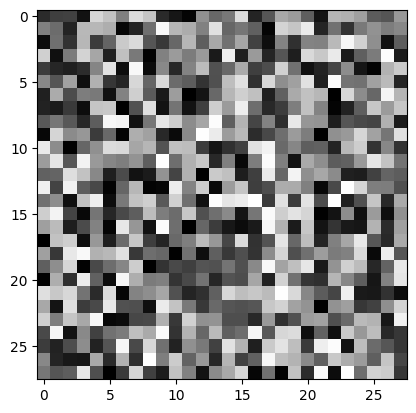

t=0:


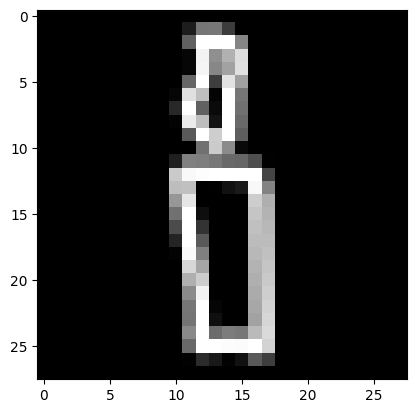

linear, t=1:


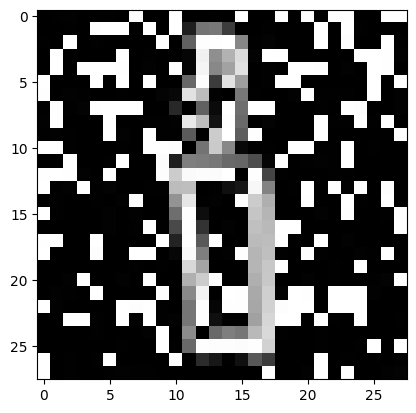

linear, t=2:


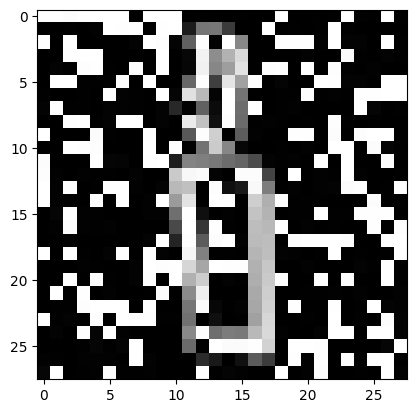

linear, t=5:


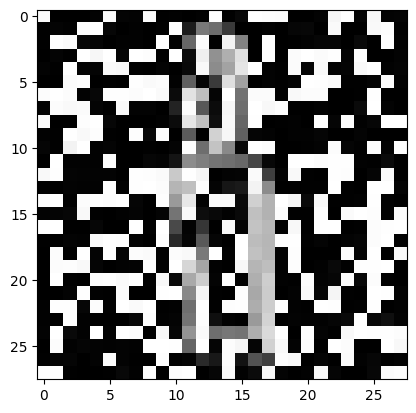

linear, t=10:


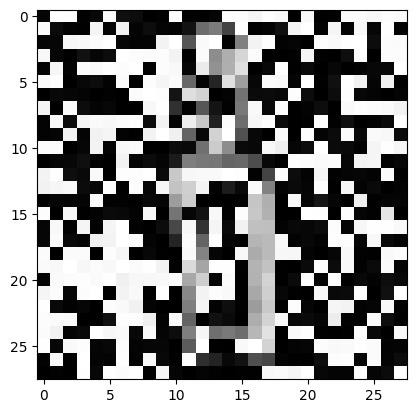

linear, t=20:


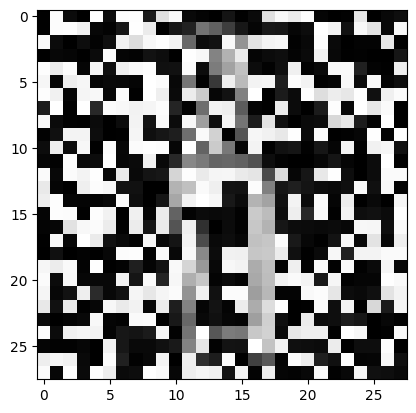

linear, t=30:


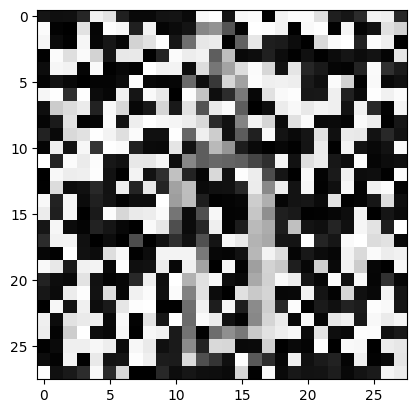

linear, t=40:


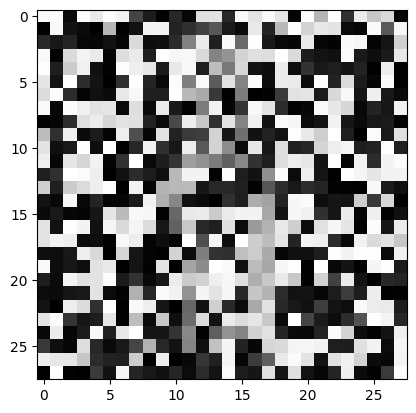

linear, t=50:


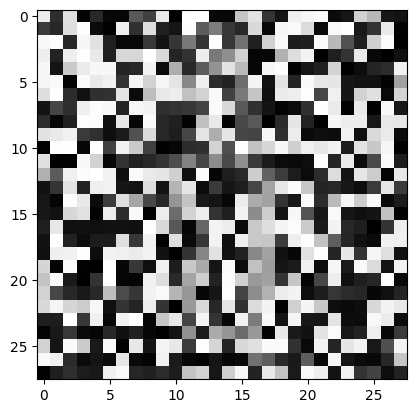

linear, t=100:


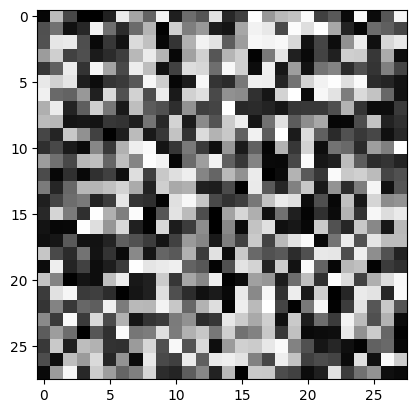

linear, t=200:


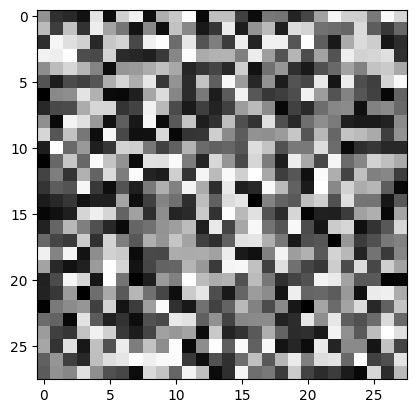

linear, t=300:


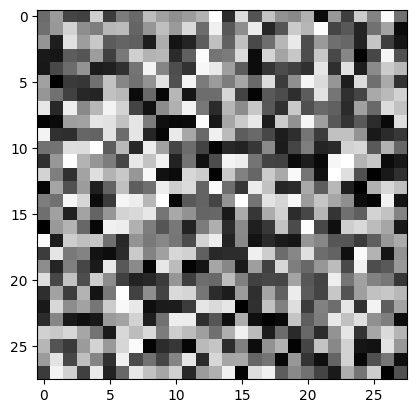

linear, t=400:


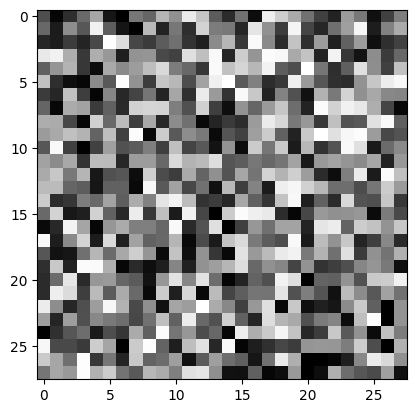

constant, t=1:


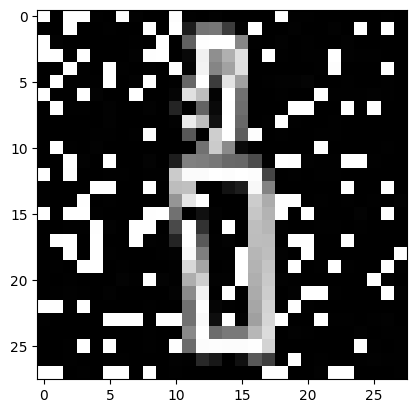

constant, t=2:


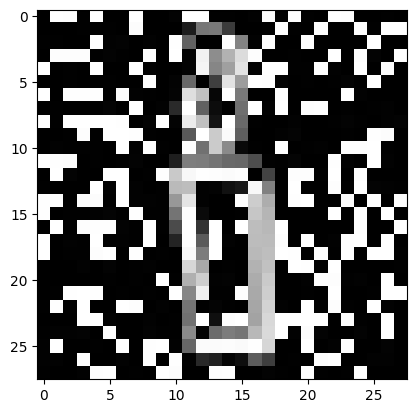

constant, t=5:


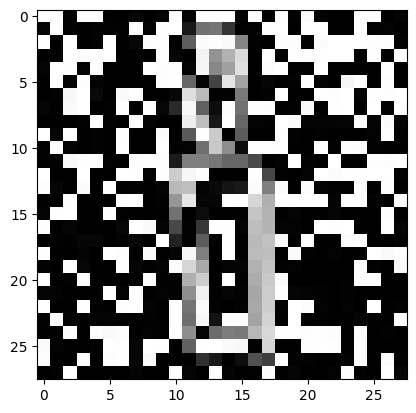

constant, t=10:


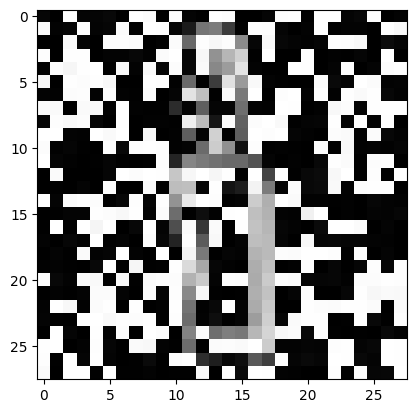

constant, t=20:


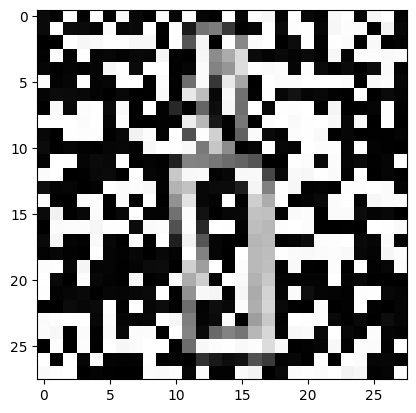

constant, t=30:


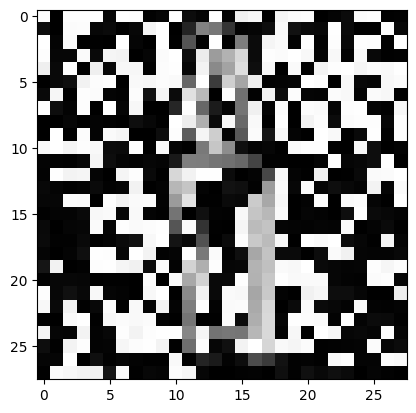

constant, t=40:


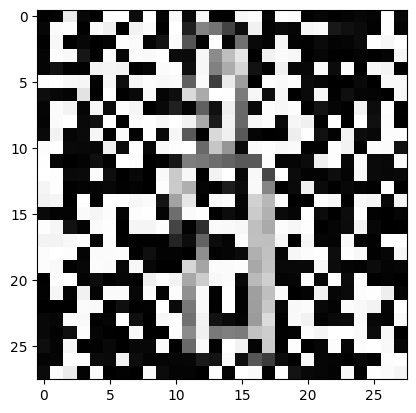

constant, t=50:


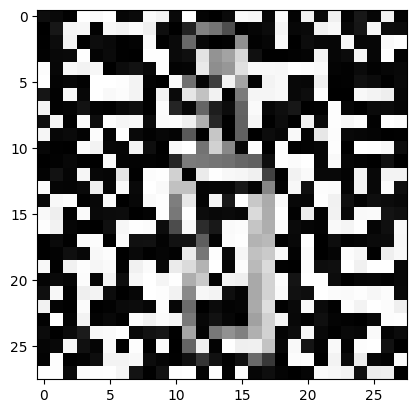

constant, t=100:


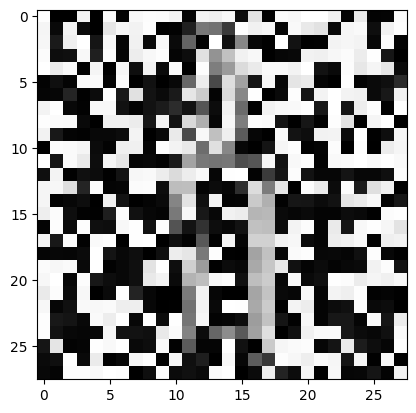

constant, t=200:


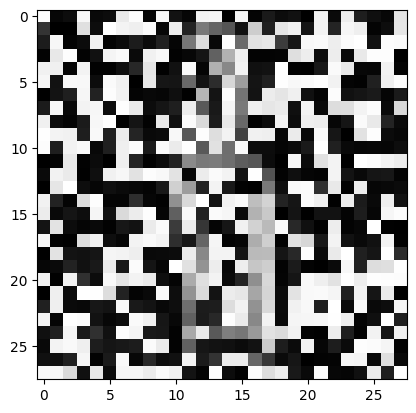

constant, t=300:


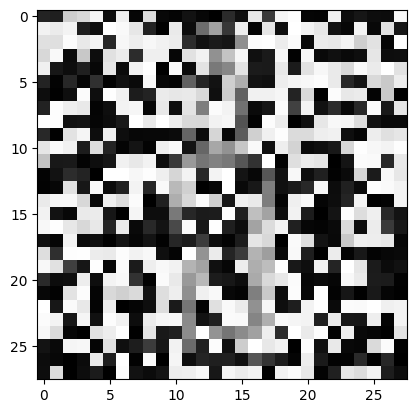

constant, t=400:


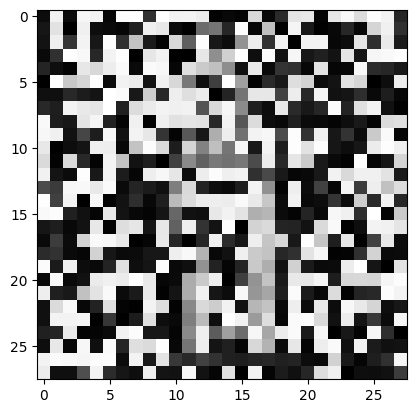

cosine, t=1:


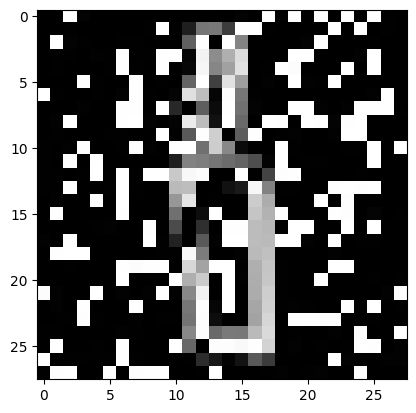

cosine, t=2:


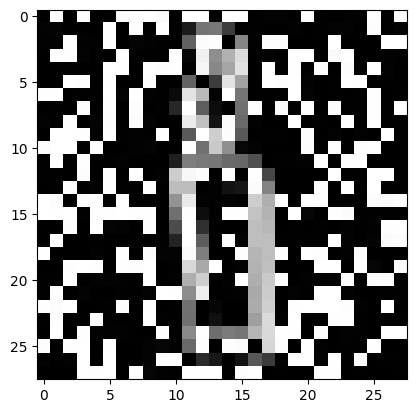

cosine, t=5:


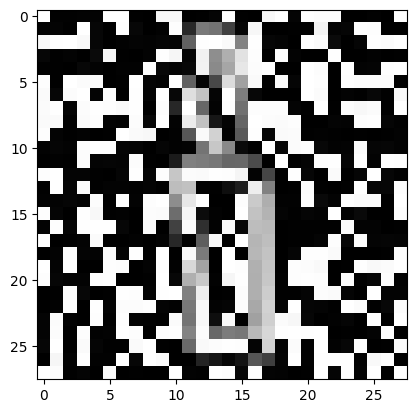

cosine, t=10:


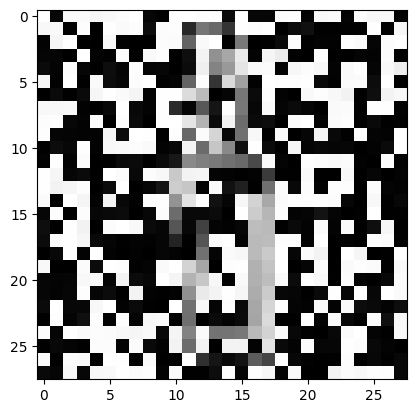

cosine, t=20:


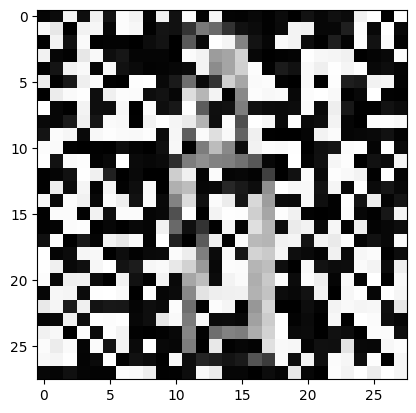

cosine, t=30:


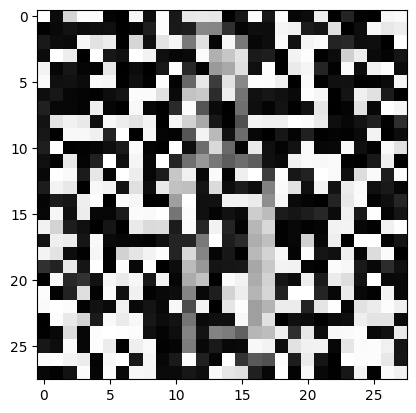

cosine, t=40:


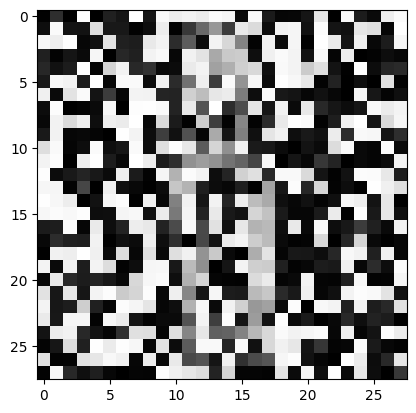

cosine, t=50:


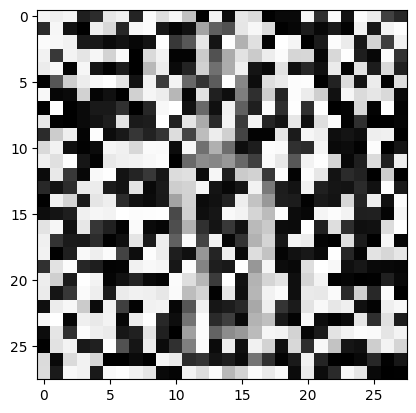

cosine, t=100:


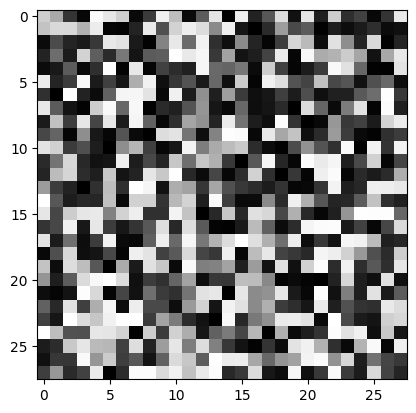

cosine, t=200:


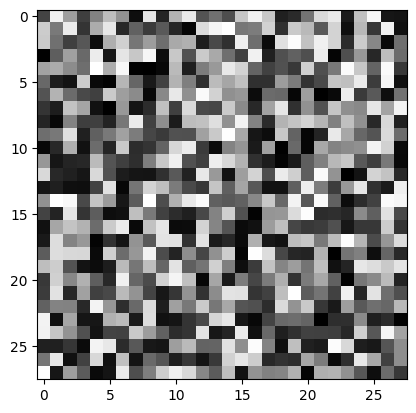

cosine, t=300:


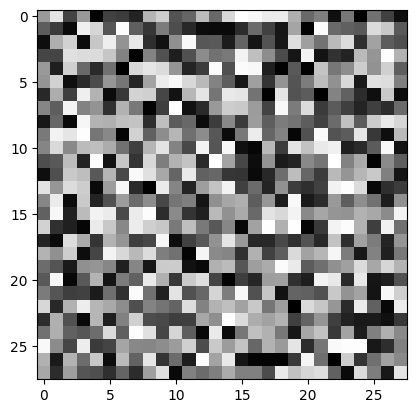

cosine, t=400:


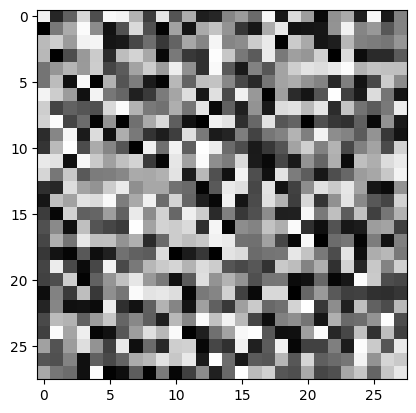

In [8]:
input_shape = (28, 28, 1)
generate_standard_noise = lambda : tfr.normal(shape=(28, 28, 1), mean=0.0, stddev=1.0)


def show_img(img):
    im = (img + 1) * 128.
    plt.imshow(im.numpy().astype("uint8")[:, :, 0], cmap='gray')
    plt.show()


def noise_img(x, t, beta):
    alpha = 1. - beta
    alpha_hat = tfm.cumprod(alpha)
    noise = generate_standard_noise()
    alpha_hat_t = alpha_hat[t]
    x_t = tfm.sqrt(alpha_hat_t) * x + tfm.sqrt(1 - alpha_hat_t) * noise
    return x_t


print("Standard noise:")
im = generate_standard_noise()
show_img(im)

img = train_dataset.take(1)
for i in img:
  print(f"t={0}:")
  im = i[0]
  show_img(im)
  for (schedule, name) in [(beta_schedule_linear(max_t, beta_from, beta_to), "linear") , (beta_schedule_constant(max_t, beta_from), "constant"), (beta_schedule_cos(max_t, beta_to), "cosine")]:
    for t in [0, 1, 4, 9, 19, 29, 39, 49, 99, 199, 299, 399, 499, 599, 699, 799, 899, 999]:
      if t > max_t:
        break
      print(f"{name}, t={t+1}:")
      im = noise_img(i[0], t, schedule)
      show_img(im)

**Training a diffusion model**

> With three different variance (beta) schedules and variable diffusion steps 



Cosine schedule

epoch 0, loss=0.18494966626167297


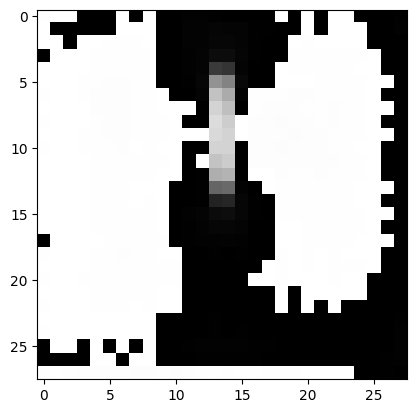

epoch 1, loss=0.07754290103912354


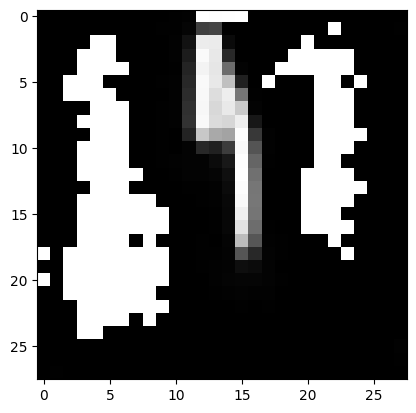

epoch 2, loss=0.06353604048490524


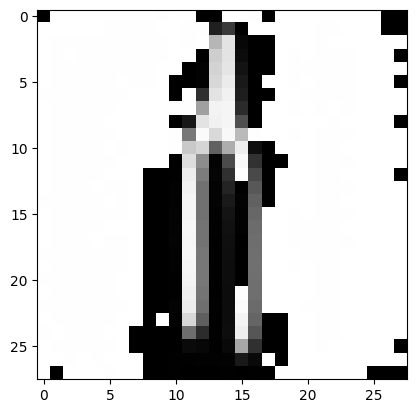

epoch 3, loss=0.057929735630750656


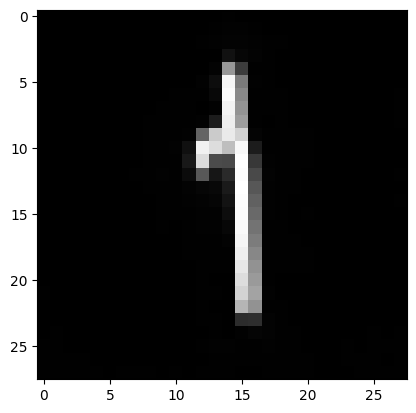

epoch 4, loss=0.05430915206670761


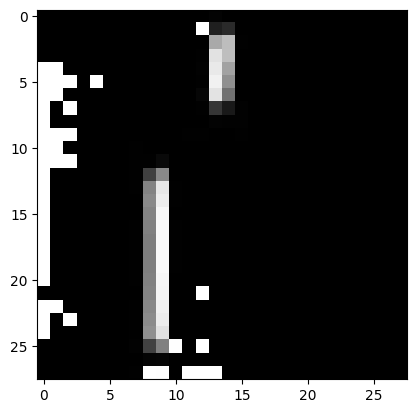

epoch 5, loss=0.05219016224145889


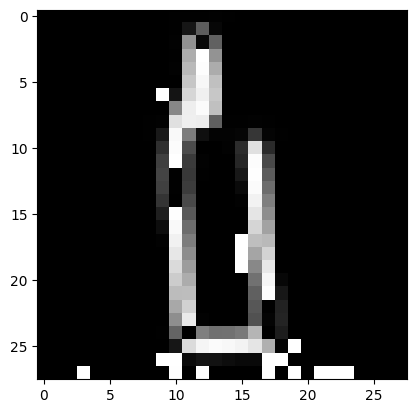

epoch 6, loss=0.05067305266857147


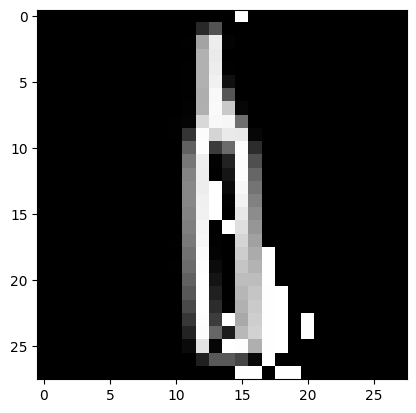

epoch 7, loss=0.04920061677694321


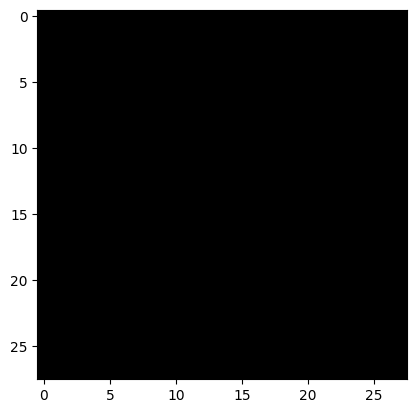

epoch 8, loss=0.047825977206230164


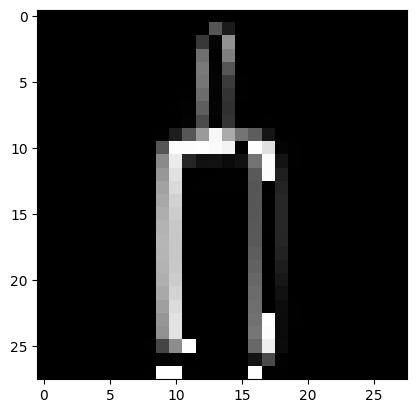

epoch 9, loss=0.04720795154571533


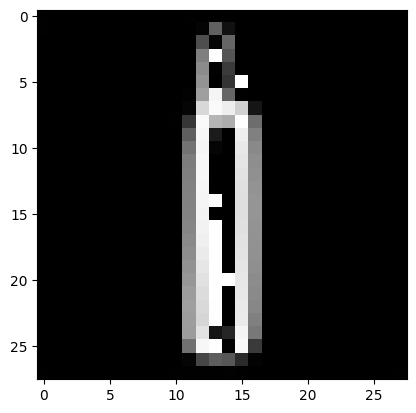

epoch 10, loss=0.04627204313874245


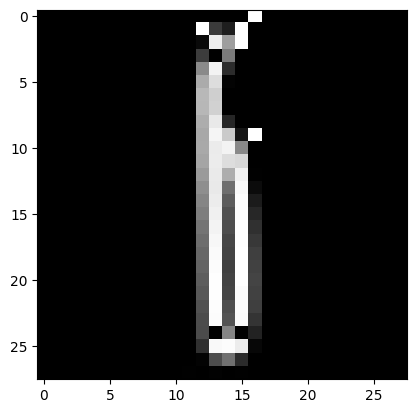

epoch 11, loss=0.045621294528245926


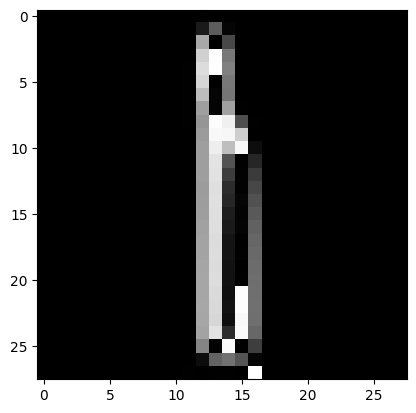

epoch 12, loss=0.045185454189777374


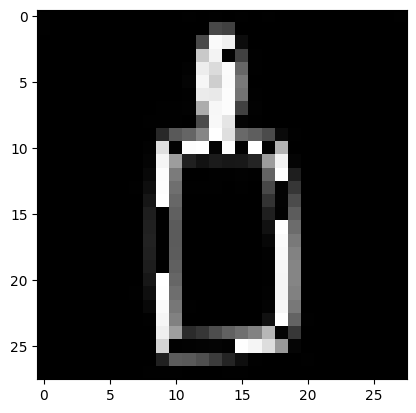

epoch 13, loss=0.04452836140990257


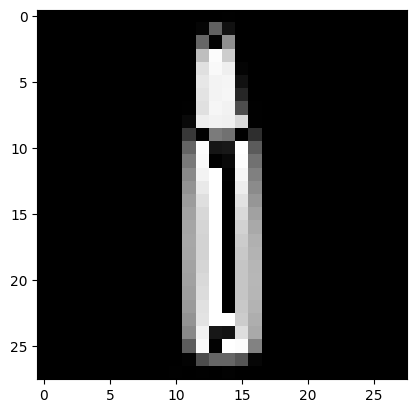

epoch 14, loss=0.04409690201282501


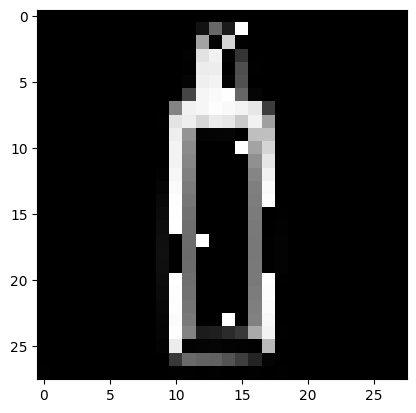

epoch 15, loss=0.04370097070932388


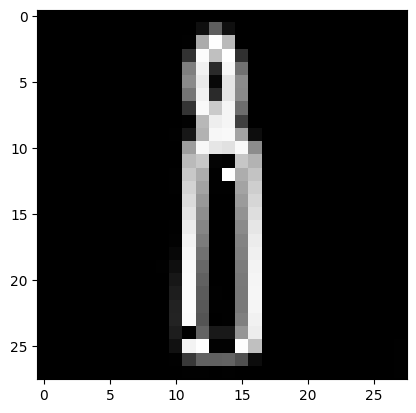

epoch 16, loss=0.04334096238017082


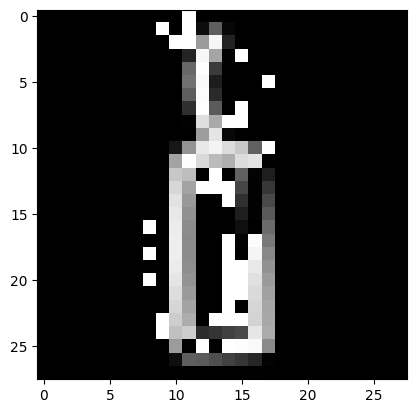

epoch 17, loss=0.04296956956386566


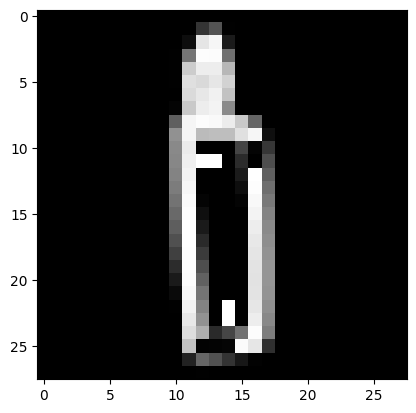

epoch 18, loss=0.04270477592945099


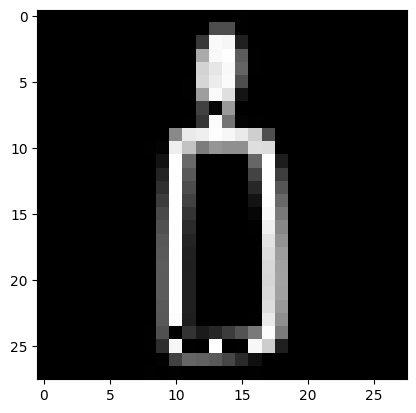

epoch 19, loss=0.04242768883705139


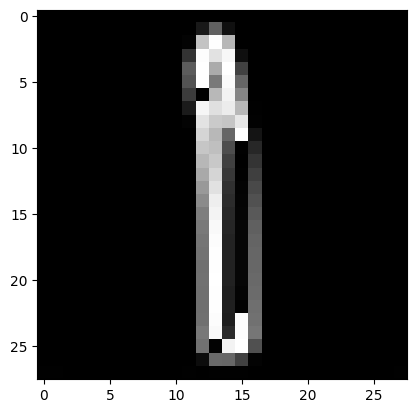

In [12]:
diffusion_steps = 400
max_beta = 0.02
beta_schedule = partial(beta_schedule_cos, max_beta=max_beta)

model = DiffusionModel(very_simple_unet, diffusion_steps=diffusion_steps, beta_schedule=beta_schedule)
model.train(train_dataset, 20)

epoch 0, loss=0.11879464238882065


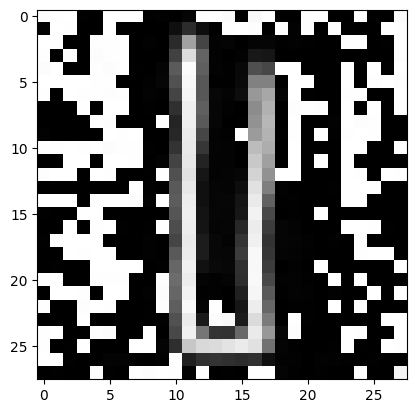

epoch 1, loss=0.051592979580163956


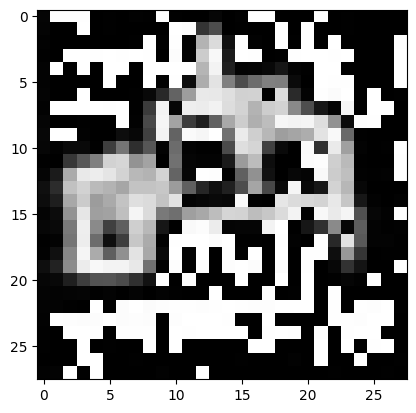

epoch 2, loss=0.04428280144929886


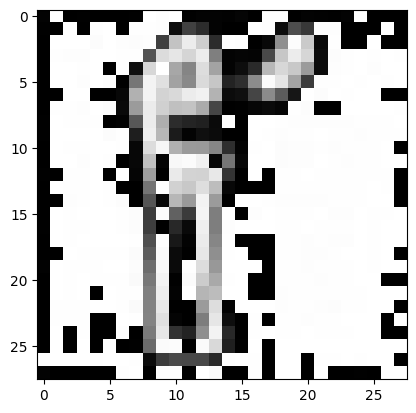

epoch 3, loss=0.04082534462213516


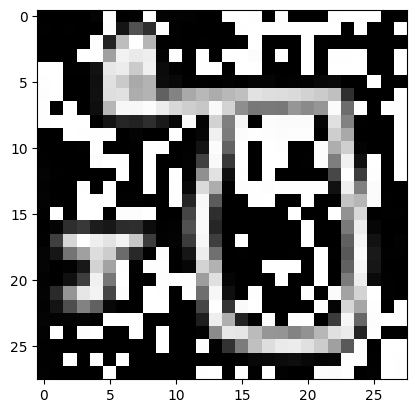

epoch 4, loss=0.038963433355093


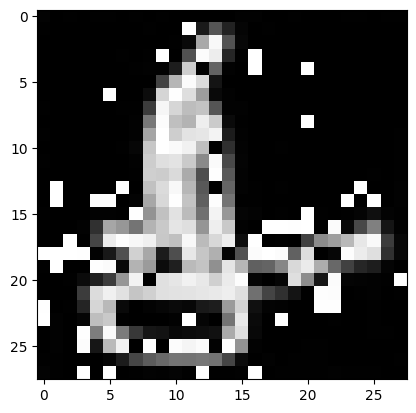

epoch 5, loss=0.037587981671094894


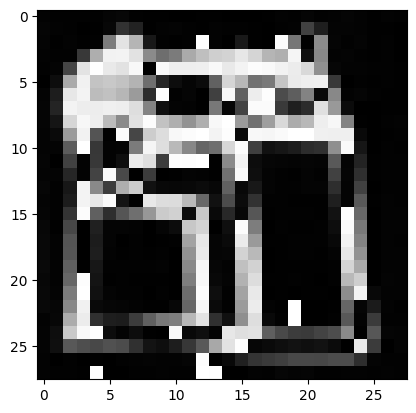

epoch 6, loss=0.036713857203722


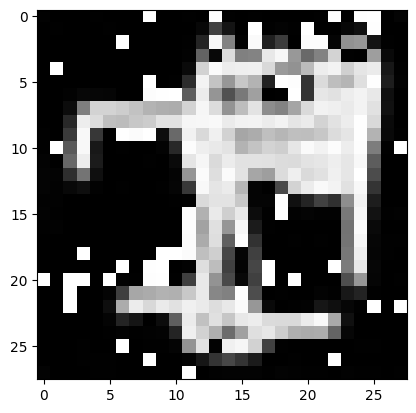

epoch 7, loss=0.0358089841902256


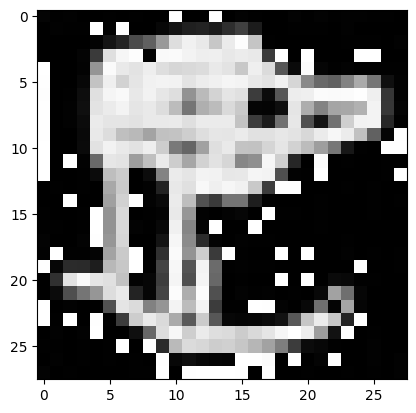

epoch 8, loss=0.035143572837114334


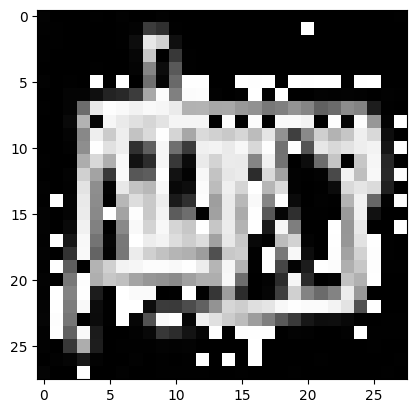

epoch 9, loss=0.034669362008571625


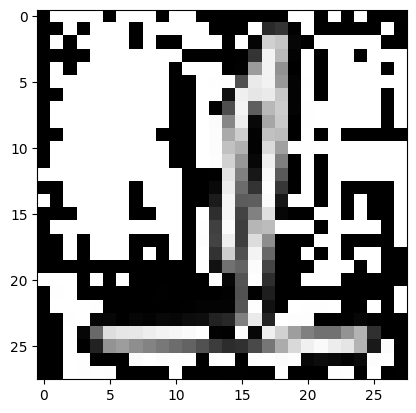

In [10]:
diffusion_steps = 400
beta = 0.005
beta_schedule = partial(beta_schedule_constant, beta=beta)

model = DiffusionModel(very_simple_unet, diffusion_steps=diffusion_steps, beta_schedule=beta_schedule)
model.train(train_dataset, 20)

Constan schedule

Linear schedule

epoch 0, loss=0.1579623818397522


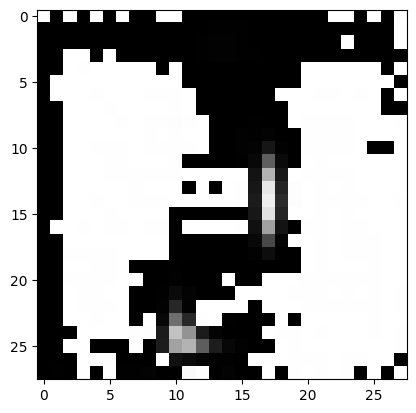

epoch 1, loss=0.070933997631073


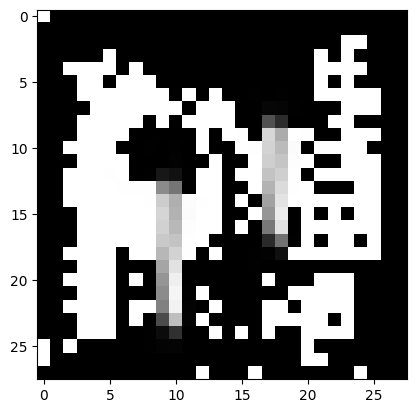

epoch 2, loss=0.057865992188453674


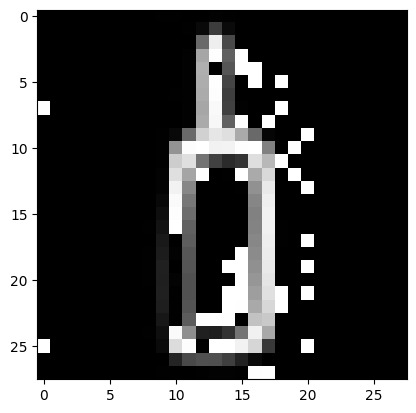

epoch 3, loss=0.052723418921232224


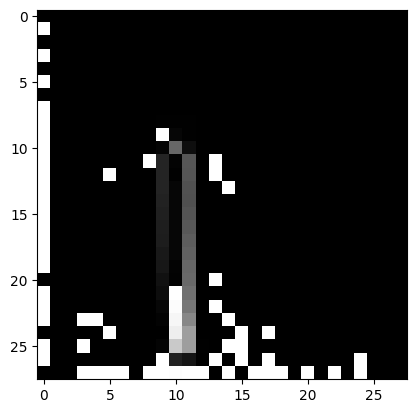

epoch 4, loss=0.04933392256498337


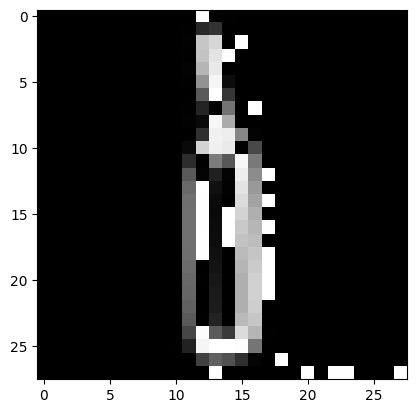

epoch 5, loss=0.047159742563962936


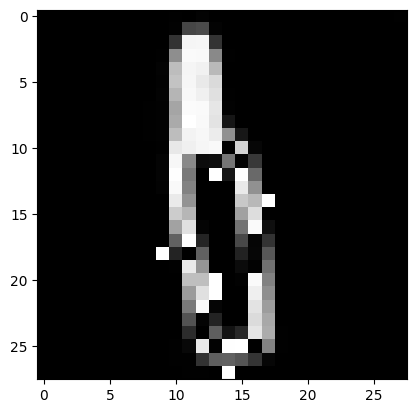

epoch 6, loss=0.045262012630701065


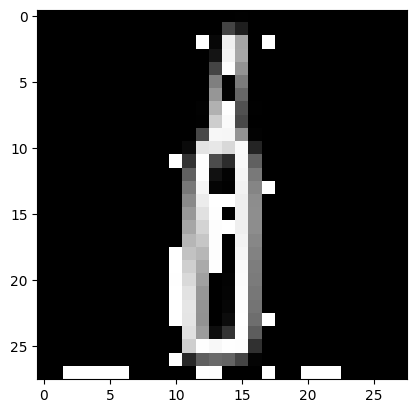

epoch 7, loss=0.04440479353070259


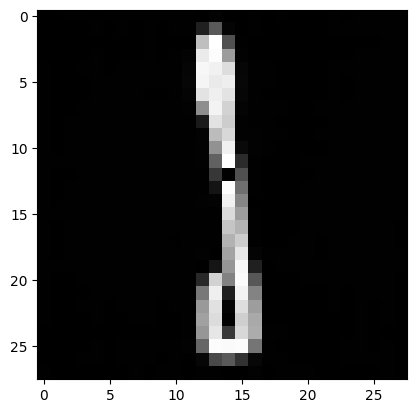

epoch 8, loss=0.04324614256620407


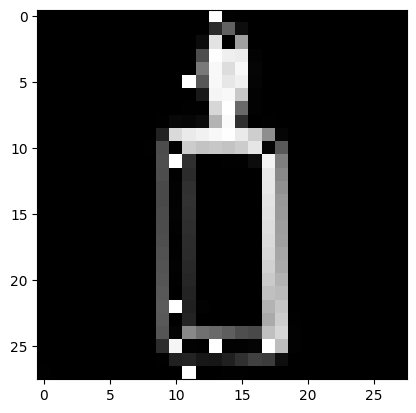

epoch 9, loss=0.042463574558496475


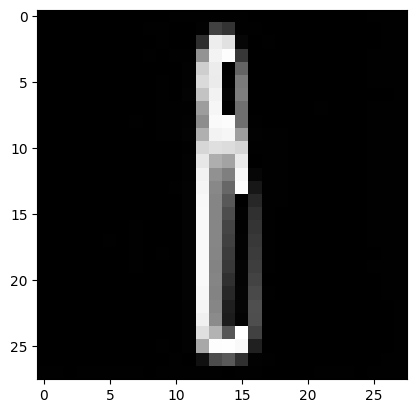

In [11]:
diffusion_steps = 400
beta_from = 0.0001
beta_to = 0.02
beta_schedule = partial(beta_schedule_linear, beta_from=beta_from, beta_to=beta_to)

model = DiffusionModel(very_simple_unet, diffusion_steps=diffusion_steps, beta_schedule=beta_schedule)
model.train(train_dataset, 20)

**Saving the trained model**

In [ ]:
model.save_parameters("my_model")

**Loading the pretrained model**

In [ ]:
diffusion_steps = 400
beta_schedule = partial(beta_schedule_cos, max_beta=0.02)

model = DiffusionModel(very_simple_unet, diffusion_steps=diffusion_steps, beta_schedule=beta_schedule)
model.load_parameters("my_model")

**Visualizing the sampling process of a DDPM**

Code for the visualization

In [13]:
def visualize_sampling(model, visualize_every_x=10):
    x = model.generate_standard_noise((1,) + model.input_shape)
    for t in range(model.time_steps, -1, -1):
        z = model.generate_standard_noise((1,) + model.input_shape) if t > 0 else 0.0
        epsilon = model.model((x, tf.convert_to_tensor([t])))
        x = 1. / tfm.sqrt(model.alpha[t]) * \
        (x - (1 - model.alpha[t]) / tf.sqrt(1 - model.alpha_hat[t]) * epsilon) + \
        model.beta[t] * z
        if t % visualize_every_x == 0:
            print(f"sampling at t={t}")
            img = (x[0] + 1) * 128.
            plt.imshow(img.numpy().astype("uint8")[:, :, 0], cmap='gray')
            plt.show()

Visualizing the sampling process with an image every *n* denoising steps

sampling at t=390


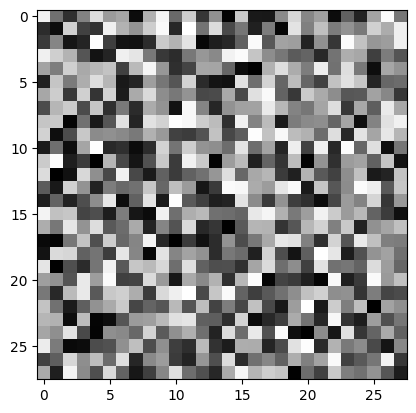

sampling at t=380


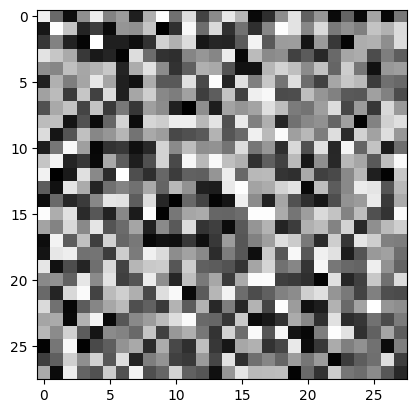

sampling at t=370


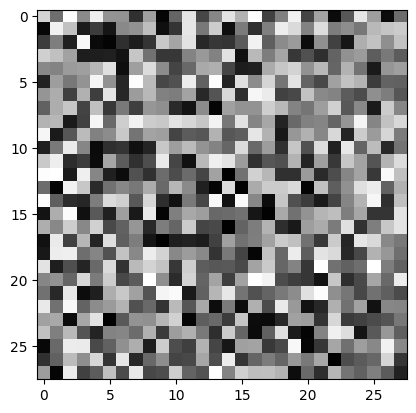

sampling at t=360


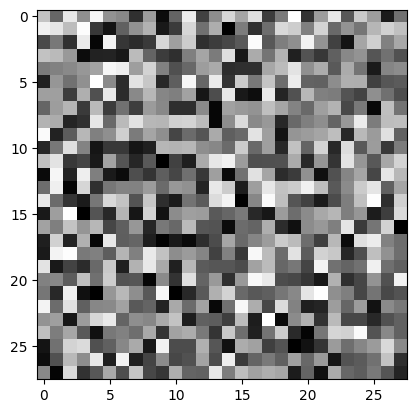

sampling at t=350


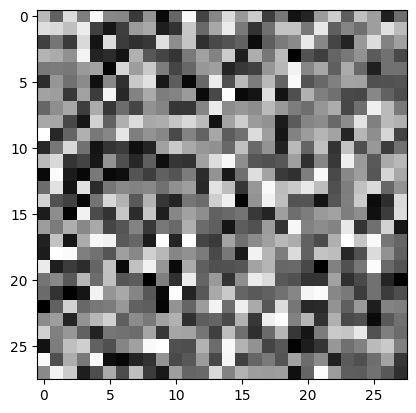

sampling at t=340


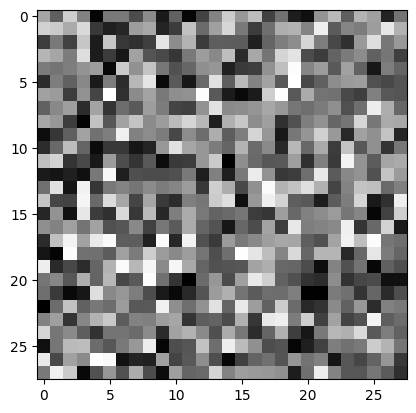

sampling at t=330


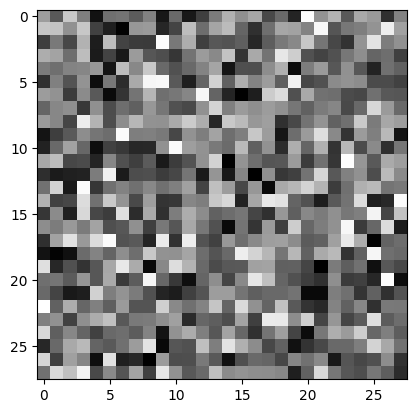

sampling at t=320


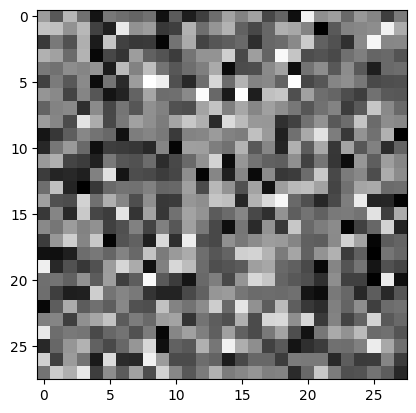

sampling at t=310


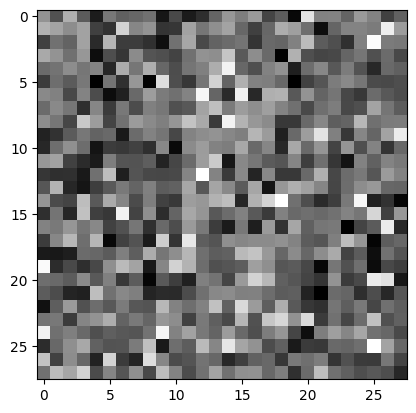

sampling at t=300


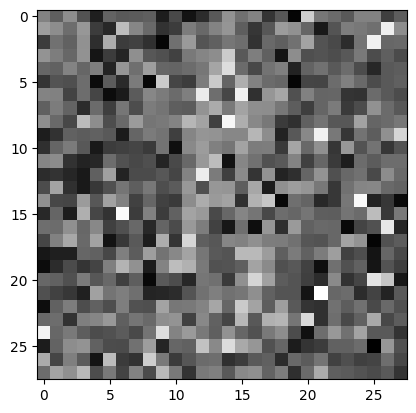

sampling at t=290


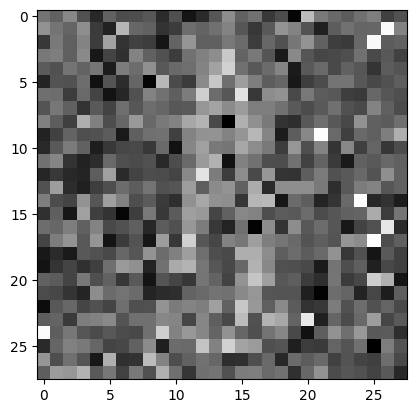

sampling at t=280


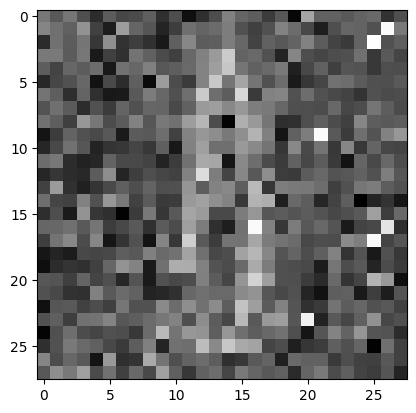

sampling at t=270


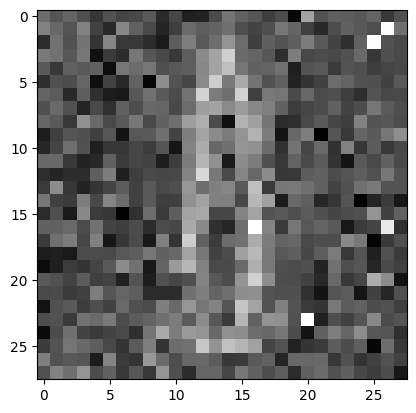

sampling at t=260


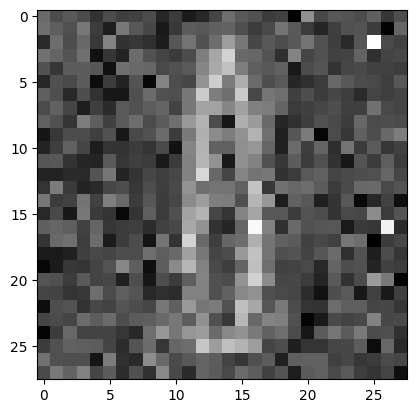

sampling at t=250


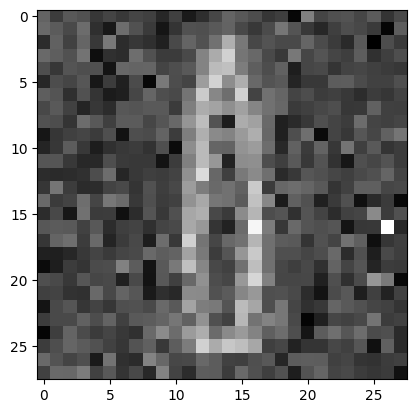

sampling at t=240


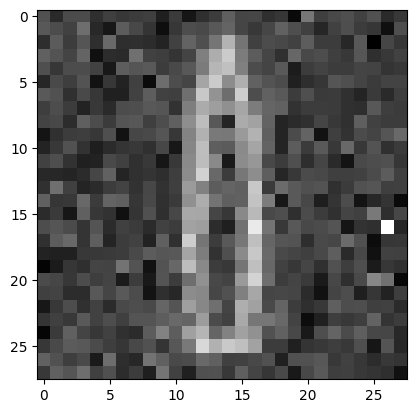

sampling at t=230


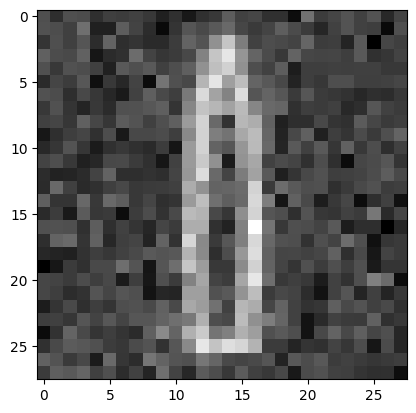

sampling at t=220


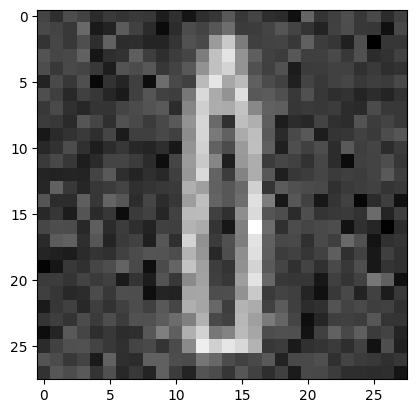

sampling at t=210


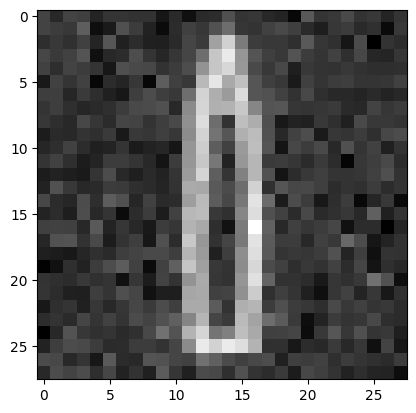

sampling at t=200


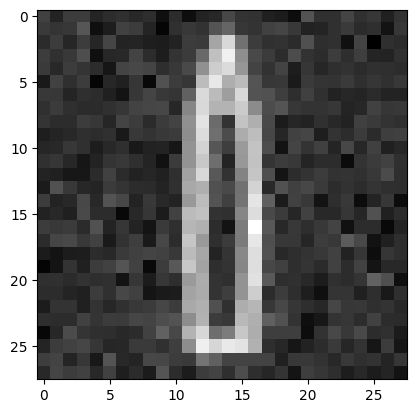

sampling at t=190


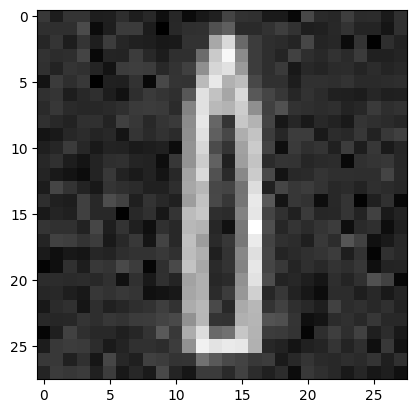

sampling at t=180


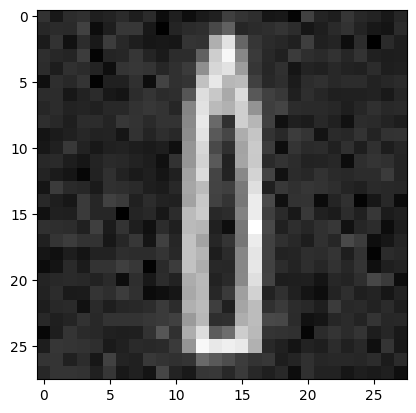

sampling at t=170


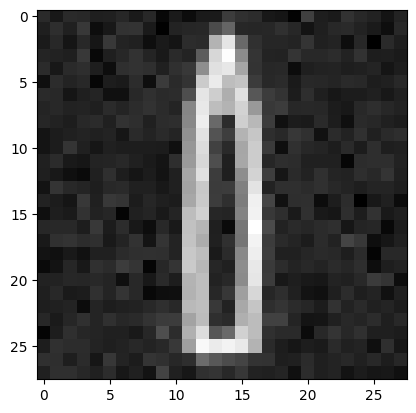

sampling at t=160


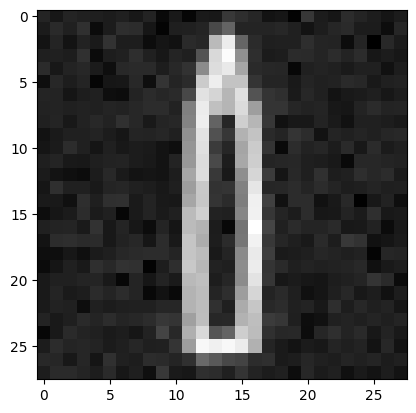

sampling at t=150


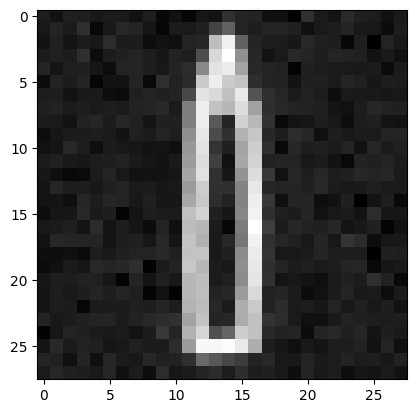

sampling at t=140


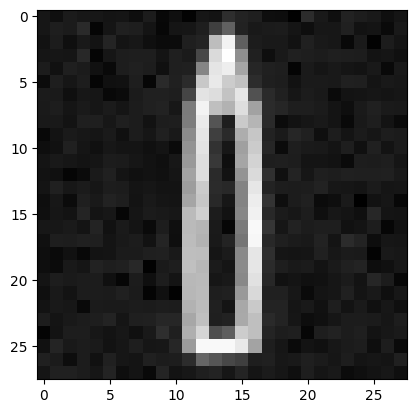

sampling at t=130


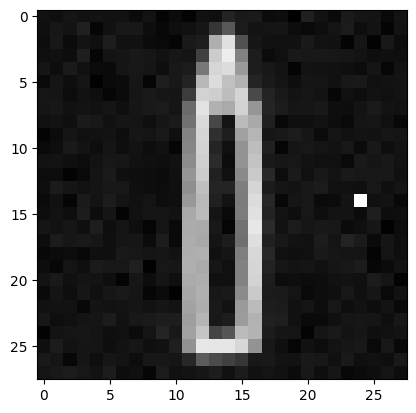

sampling at t=120


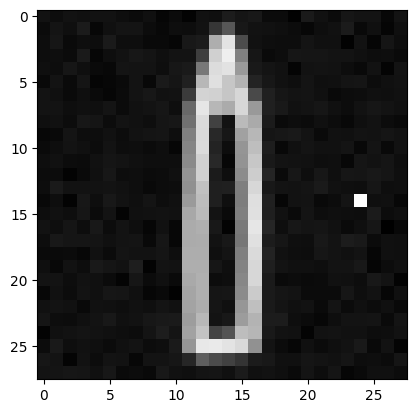

sampling at t=110


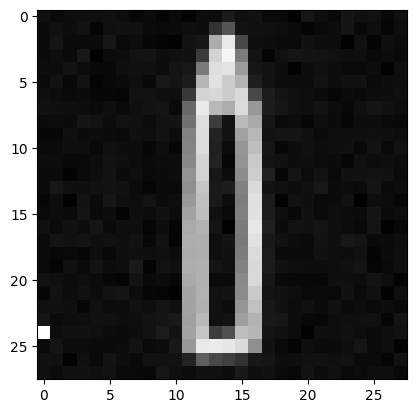

sampling at t=100


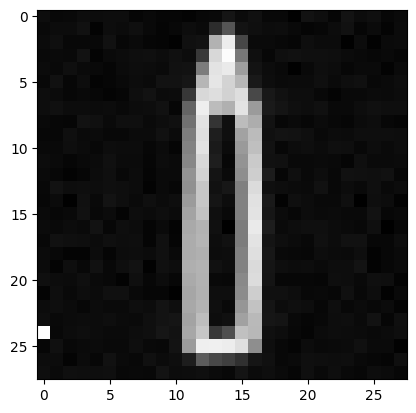

sampling at t=90


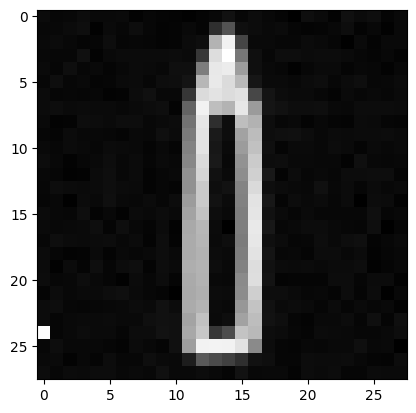

sampling at t=80


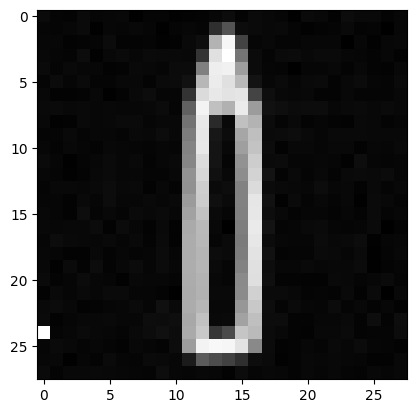

sampling at t=70


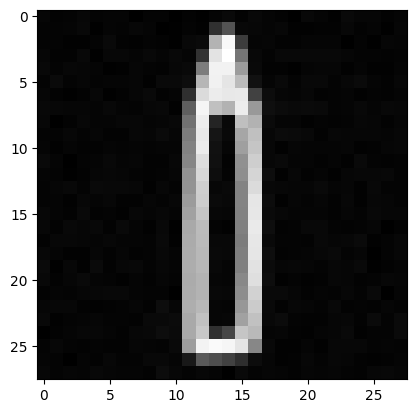

sampling at t=60


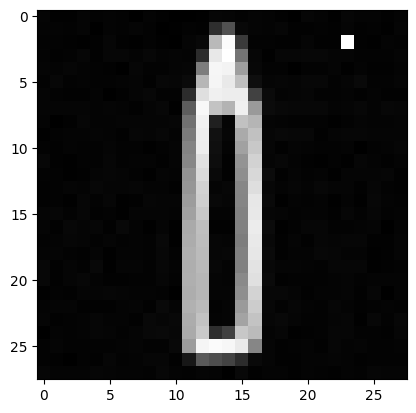

sampling at t=50


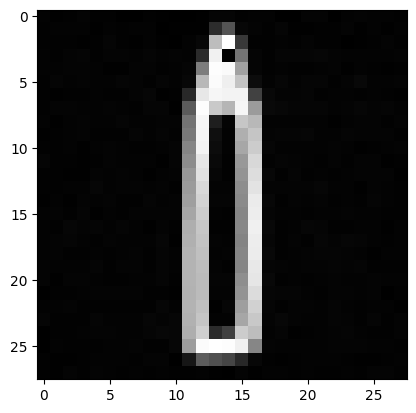

sampling at t=40


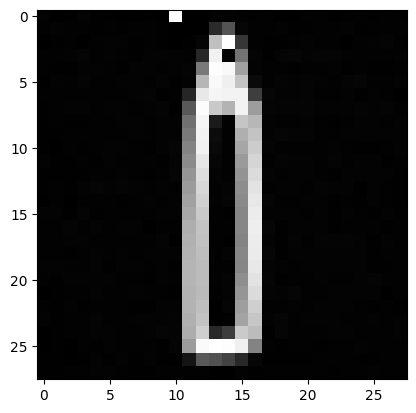

sampling at t=30


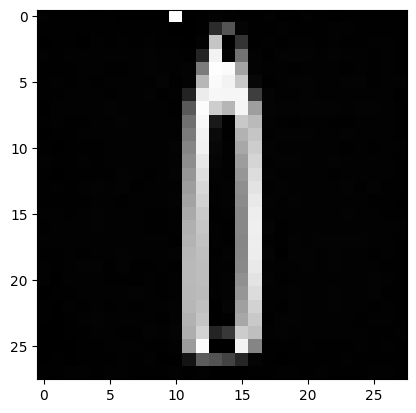

sampling at t=20


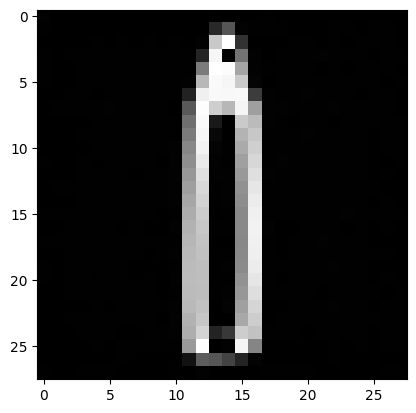

sampling at t=10


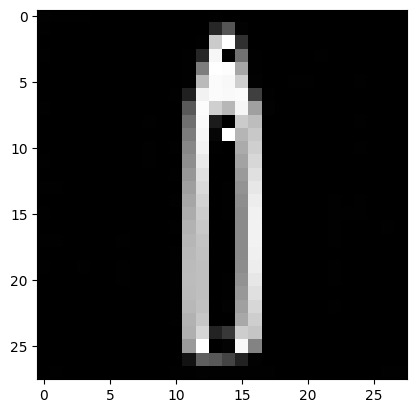

sampling at t=0


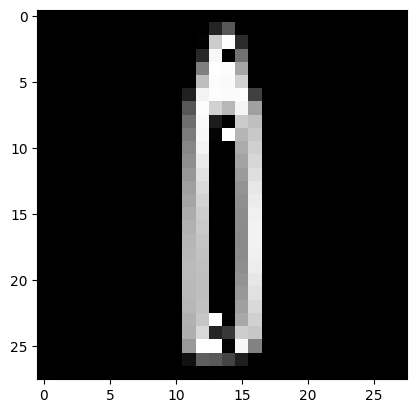

In [14]:
n = 10
visualize_sampling(model, n)